In [6]:
# @title Section 1: Setup

## Check GPU
!nvidia-smi

## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## Install necessary libraries
!pip install -U transformers shap
!pip install textblob

Mon Jun 17 20:04:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# @title Section 2: Import Libraries

### Przetwarzanie i Analiza Danych
import pandas as pd
import numpy as np

### Uczenie Maszynowe i Deep Learning
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification


### Wizualizacja Danych
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Przedprocesowanie Danych
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Przypadkowe Operacje i Manipulacja Tekstem
import random
import string
import re

### Przetwarzanie Języka Naturalnego
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

### Interpretacja Modeli
import shap

### Przetwarzanie Równoległe
from multiprocessing import Pool

In [8]:
# @title Section 3: Clean Data Functions

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize necessary tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Normalize text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    words = nltk.word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Perform stemming and lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join words into a single string separated by spaces
    cleaned_text = ' '.join(lemmatized_words)

    return cleaned_text


# Function to clean a list of texts using multiprocessing
def clean_texts_in_parallel(texts, num_processes=4):
    with Pool(num_processes) as pool:
        cleaned_texts = pool.map(clean_text, texts)
    return cleaned_texts


def get_synonym(word):
    synsets = wordnet.synsets(word)
    if synsets:
        synonyms = synsets[0].lemmas()  # Get the first synonym set and its lemmas
        if synonyms:
            return synonyms[0].name()  # Return the name of the first lemma as synonym
    return word  # Return the original word if no synonyms are found

def augment_text(text):
    words = text.split()
    num_words = len(words)

    if num_words <= 1:
        return text  # Return the original text if it's too short

    aug_word_idx = random.randint(0, num_words - 1)
    synonym = get_synonym(words[aug_word_idx])  # Get a synonym for the selected word

    words[aug_word_idx] = synonym
    augmented_text = ' '.join(words)

    return augmented_text

def augment_texts_in_parallel(texts):
    # from multiprocessing import Pool

    with Pool() as pool:
        texts_augmented = pool.map(augment_text, texts)

    return texts_augmented



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# @title Section 4: Load, Clean and Augment Data

# ## Load the dataset
file_path = 'drive/MyDrive/realdonaldtrump/test.xls'
df = pd.read_csv(file_path, encoding='latin1')

## Clean the data
df_cleaned = df.dropna(subset=['text', 'sentiment'])
texts_cleaned = clean_texts_in_parallel(df_cleaned['text'].tolist())
labels_cleaned = df_cleaned['sentiment'].tolist()


# Clean texts in parallel
texts_cleaned = clean_texts_in_parallel(texts_cleaned)

# Augment cleaned texts in parallel
texts_augmented = augment_texts_in_parallel(texts_cleaned)

# Combine original and augmented texts
texts_cleaned = texts_cleaned + texts_augmented
labels_cleaned = labels_cleaned + labels_cleaned  # Duplicate labels for augmented data


print(df_cleaned.head())
print(texts_cleaned[0:10])
print(labels_cleaned[0:10])

## Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')


       textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon       60-70       Angola        32866272.0        1246700.0   

   Density (P/Km²)  
0             60.0  
1            1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [10]:
# @title Section 5: Define Helper Functions For Training

## Function to tokenize data
def tokenize_data(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text, # Clean the data
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids="token_type_ids" in tokenizer.model_input_names,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, scaler, patience=3):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        # Early stopping logic
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs.')
                break

    return train_losses, val_losses, epoch


## Function to evaluate model accuracy
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            _, predicted = torch.max(outputs.logits, 1)
            total += b_labels.size(0)
            correct += (predicted == b_labels).sum().item()
    return correct / total

## Function to plot losses
def plot_losses(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

## Function to save predictions to a file
def save_predictions_to_file(texts, sentiments, filename="result.txt"):
    with open(filename, "w") as f:
        for text, sentiment in zip(texts, sentiments):
            f.write(f'Text: {text}\n')
            f.write(f'Predicted Sentiment: {sentiment}\n')
            f.write('-' * 80 + '\n')

# Function to predict sentiment labels in batches
def predict_sentiment_batches(texts, batch_size=128):
    num_texts = len(texts)
    predicted_labels = []
    for i in range(0, num_texts, batch_size):
        batch_texts = texts[i:i+batch_size]
        input_ids, attention_masks = tokenize_data(batch_texts, tokenizer)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        _, batch_predicted = torch.max(outputs.logits, 1)
        predicted_labels.extend(batch_predicted.cpu().numpy())
    return predicted_labels



In [11]:
# @title Section 6: Prepare Data for Model

## Tokenize the cleaned texts
input_ids, attention_masks = tokenize_data(texts_cleaned, tokenizer)

## Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_cleaned)
labels_tensor = torch.tensor(labels_encoded)

## Split the data into training and validation sets
X_train_ids, X_val_ids, y_train, y_val = train_test_split(input_ids, labels_tensor, test_size=0.2, random_state=42)
X_train_masks, X_val_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)

## Create datasets and dataloaders
train_dataset = TensorDataset(X_train_ids, X_train_masks, y_train)
val_dataset = TensorDataset(X_val_ids, X_val_masks, y_val)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# @title Section 7: Initialize and Train the Model

## Initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(np.unique(labels_encoded)))
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * 10  # num_epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

## Train the model
num_epochs = 20
train_losses, val_losses, num_of_epochs = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, scaler)

## Save the model weights after training
torch.save(model.state_dict(), 'model_weights.pth')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20, Train Loss: 0.9617, Val Loss: 0.7032
Epoch 2/20, Train Loss: 0.6261, Val Loss: 0.6045
Epoch 3/20, Train Loss: 0.4933, Val Loss: 0.5196
Epoch 4/20, Train Loss: 0.3850, Val Loss: 0.4896
Epoch 5/20, Train Loss: 0.3051, Val Loss: 0.3962
Epoch 6/20, Train Loss: 0.2385, Val Loss: 0.3960
Epoch 7/20, Train Loss: 0.1917, Val Loss: 0.3504
Epoch 8/20, Train Loss: 0.1641, Val Loss: 0.3410
Epoch 9/20, Train Loss: 0.1459, Val Loss: 0.3296
Epoch 10/20, Train Loss: 0.1372, Val Loss: 0.3291
Epoch 11/20, Train Loss: 0.1382, Val Loss: 0.3291
Epoch 12/20, Train Loss: 0.1349, Val Loss: 0.3291
Epoch 13/20, Train Loss: 0.1305, Val Loss: 0.3291
Early stopping triggered after 13 epochs.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Accuracy: 0.9791
Validation Accuracy: 0.9017


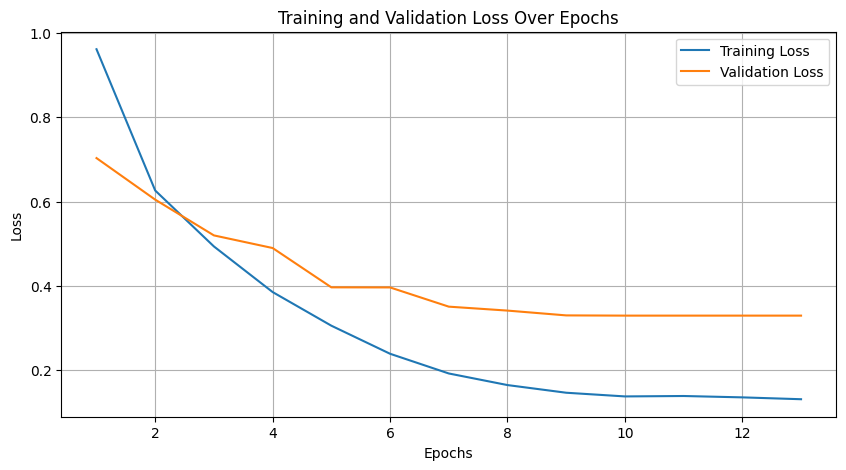

In [13]:
# @title Section 8: Evaluate the Model

## Load the saved model weights into a new model instance
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(np.unique(labels_encoded)))
model = model.to(device)
model.load_state_dict(torch.load('model_weights.pth'))

## Set the model to evaluation mode
model.eval()

## Evaluate the model
train_accuracy = evaluate_accuracy(model, train_loader)
val_accuracy = evaluate_accuracy(model, val_loader)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

## Plot training and validation losses
plot_losses(train_losses, val_losses, num_of_epochs+1)

In [14]:
# @title Section 9: Predict Sentiment

def predict_sentiment(texts, batch_size=128):
    num_texts = len(texts)
    predicted_labels = []

    for i in range(0, num_texts, batch_size):
        texts_batch = texts[i:i+batch_size]
        input_ids, attention_masks = tokenize_data(texts_batch, tokenizer)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)

        _, predicted = torch.max(outputs.logits, 1)
        predicted_labels.extend(predicted.cpu().numpy())

    return np.array(predicted_labels)

batch_size = 128
predicted_labels = []

for i in range(0, len(texts_cleaned), batch_size):
    texts_batch = texts_cleaned[i:i+batch_size]
    batch_predicted_labels = predict_sentiment(texts_batch)
    predicted_labels.extend(batch_predicted_labels)


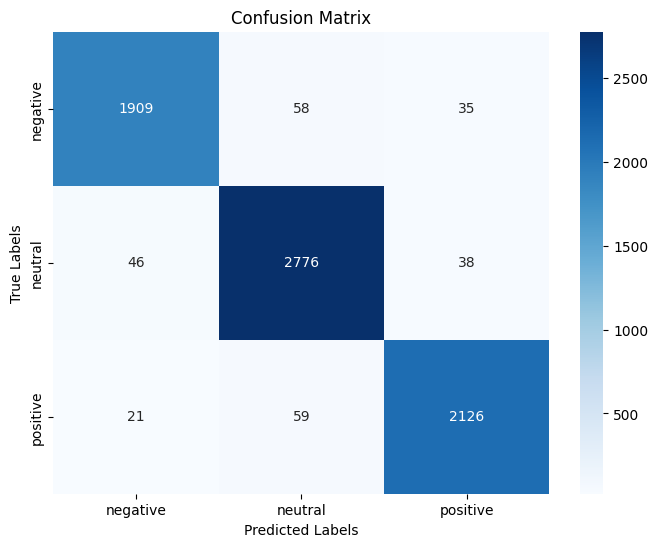

In [15]:
# @title Section 10: Confusion Matrix

# Convert numerical labels to original sentiment classes
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)
true_sentiments = label_encoder.inverse_transform(labels_encoded)

# # Compute confusion matrix
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_sentiments, predicted_sentiments, labels=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0, 1]
Sentiment Counts:
negative    34445
neutral      8907
Name: count, dtype: int64

Sentiment Percentages:
negative    79.454235
neutral     20.545765
Name: count, dtype: float64

Examples of negative posts:
- To the men who sit behind me, and to the boys who rest in the field before me: your example will never grow old. Your legend will never tire, and your spirit - brave, unyielding, and true - will NEVER DIE! # DDay75thAnniversarypic.twitter.com/5qwQjkvHdl
- For all of the political hacks out there, if I hadn’t done my job well, & early, we would have lost 1 1/2 to 2 Million People, as opposed to the 100,000 plus that looks like will be the number. That’s 15 to 20 times more than we will lose. I shut down entry from China very early!
- Russia started their anti-US campaign in 2014, long before I announced that I would run for President. The results of the election were not impacted. The Trump campaign did nothing wrong - no collusion!

Examples of neutral posts:
- " @ barrman: @

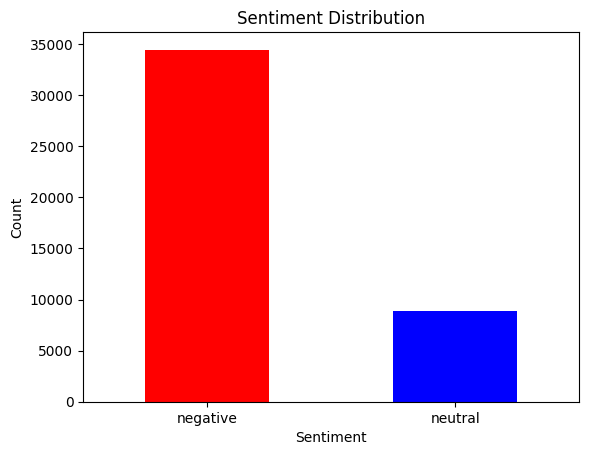

In [24]:
# @title Section 11: Real Donald Trump Data Analysis ans Statistics

# Load the data
filename = 'drive/MyDrive/realdonaldtrump/realdonaldtrump.csv'
df = pd.read_csv(filename)
texts_to_analyze = df['content'].tolist()

# Clean texts in parallel
cleaned_texts = clean_texts_in_parallel(texts_to_analyze, num_processes=4)

# Function to predict sentiments in batches
def predict_sentiments_in_batches(texts, batch_size=32):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(batch_predictions)
    return predictions

# # Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Predict sentiments for the texts in batches
predicted_labels = predict_sentiments_in_batches(cleaned_texts, batch_size=128)

print(list(set(predicted_labels)))

# Convert numerical labels to sentiment classes
sentiment_classes = ['negative', 'neutral', 'positive']
predicted_sentiments = [sentiment_classes[label] for label in predicted_labels]

# Compute sentiment statistics
sentiment_counts = pd.Series(predicted_sentiments).value_counts()
sentiment_percentages = sentiment_counts / len(predicted_sentiments) * 100

# Print the statistics
print("Sentiment Counts:")
print(sentiment_counts)
print("\nSentiment Percentages:")
print(sentiment_percentages)

# Display some example posts for each sentiment
df['predicted_sentiment'] = predicted_sentiments
for sentiment in sentiment_classes:
    print(f"\nExamples of {sentiment} posts:")
    dff=df[df['predicted_sentiment'] == sentiment]['content']
    if len(dff)>0:
      examples = df[df['predicted_sentiment'] == sentiment]['content'].sample(n=3).tolist()
      for example in examples:
          print(f"- {example}")

# Plot sentiment distribution
import matplotlib.pyplot as plt
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [29]:
# @title Section 12: SHAP Analysis on Real Donald Trump Posts Part 1 - Prepare Data And Functions

## Function to tokenize data
def tokenize_data(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return {'input_ids': torch.cat(input_ids, dim=0), 'attention_mask': torch.cat(attention_masks, dim=0)}


## Function to make predictions using the model and tokenize text
def shap_predict(texts):
    inputs = tokenize_data(texts, tokenizer)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits.cpu().numpy()

## Explain the model's predictions using SHAP
explainer = shap.Explainer(shap_predict, tokenizer, output_names=['negative', 'neutral', 'positive'])

## Randomly shuffle and analyze the first 100 predictions
random.shuffle(texts_cleaned)

PartitionExplainer explainer: 101it [00:52,  1.69it/s]


SHAP values for positive sentiment


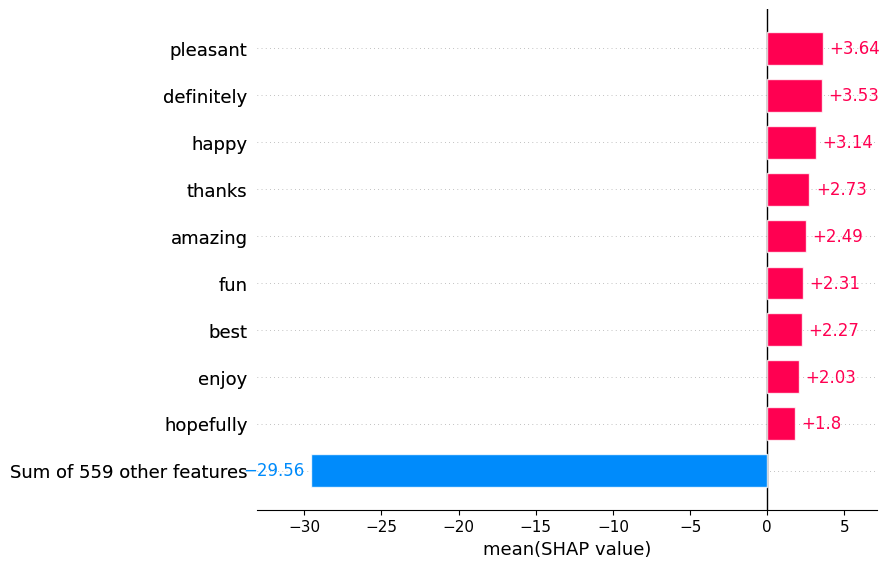

SHAP values for negative sentiment


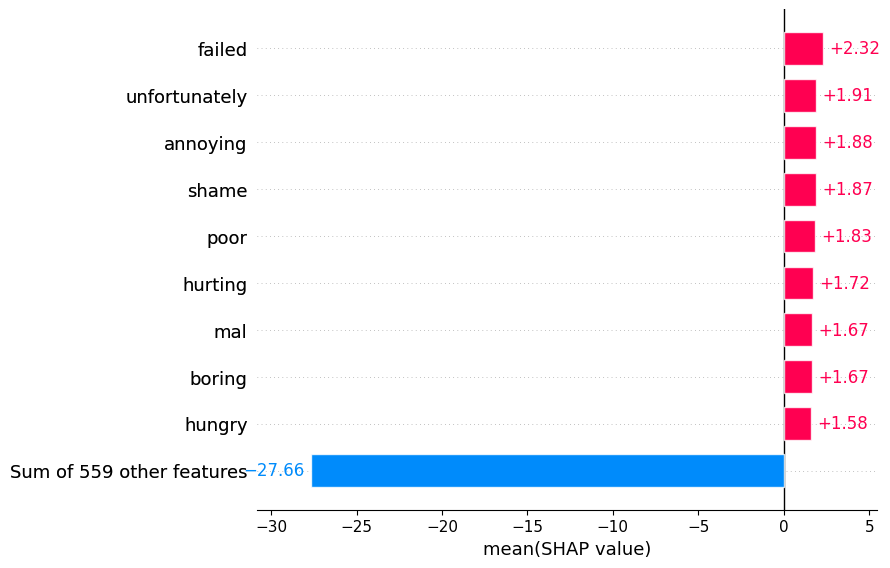

SHAP values for neutral sentiment


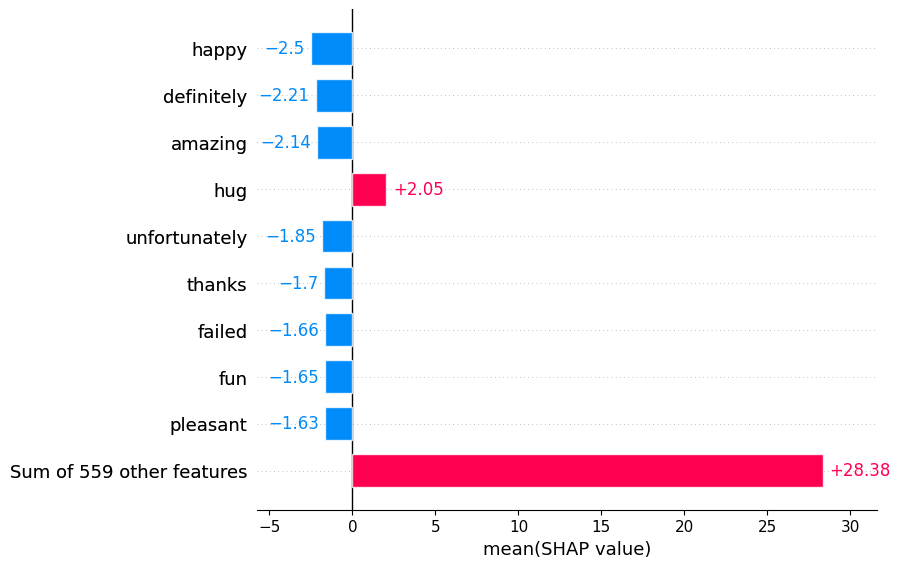

PartitionExplainer explainer: 101it [00:44,  1.68it/s]


SHAP values for positive sentiment


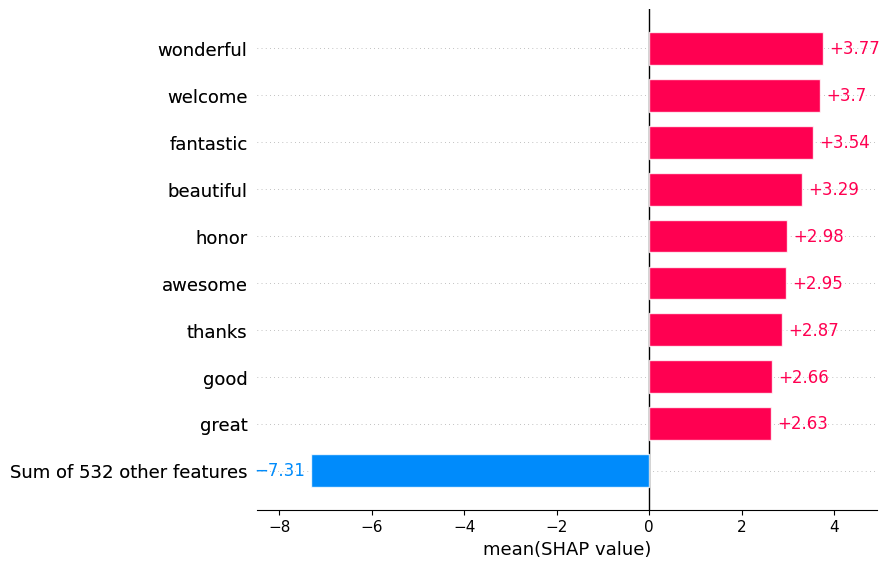

SHAP values for negative sentiment


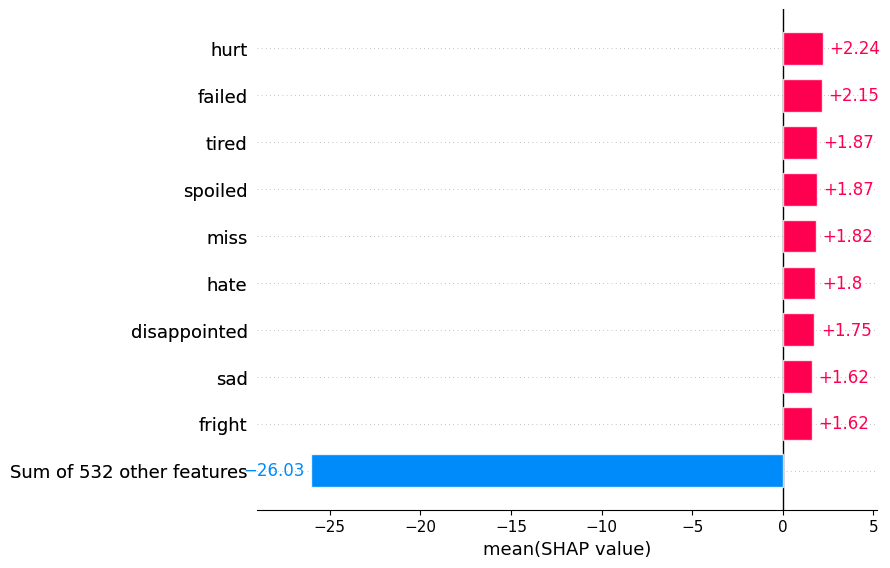

SHAP values for neutral sentiment


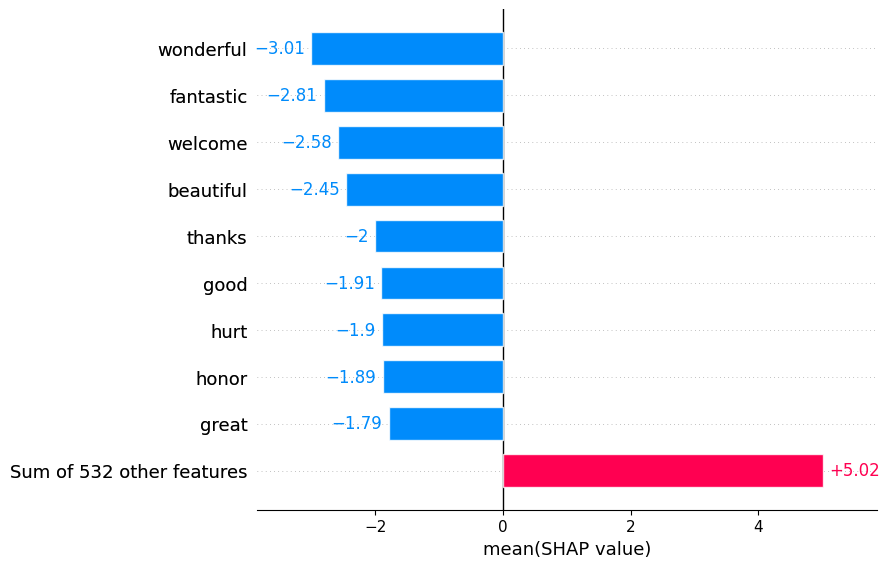

In [30]:
# @title Section 13: SHAP Analysis on Real Donald Trump Posts Part 2 - Draw Bar Plots

## Analyze a set of 100 predictions
shap_values = explainer(texts_cleaned[:100])

## Plot SHAP values for positive sentiment
print("SHAP values for positive sentiment")
shap.plots.bar(shap_values[:, :, "positive"].mean(0))

## Plot SHAP values for negative sentiment
print("SHAP values for negative sentiment")
shap.plots.bar(shap_values[:, :, "negative"].mean(0))

## Plot SHAP values for neutral sentiment
print("SHAP values for neutral sentiment")
shap.plots.bar(shap_values[:, :, "neutral"].mean(0))

## Analyze another set of 100 predictions
shap_values_2 = explainer(texts_cleaned[100:200])

## Plot SHAP values for positive sentiment
print("SHAP values for positive sentiment")
shap.plots.bar(shap_values_2[:, :, "positive"].mean(0))

## Plot SHAP values for negative sentiment
print("SHAP values for negative sentiment")
shap.plots.bar(shap_values_2[:, :, "negative"].mean(0))

## Plot SHAP values for neutral sentiment
print("SHAP values for neutral sentiment")
shap.plots.bar(shap_values_2[:, :, "neutral"].mean(0))


In [33]:
# @title Section 14: SHAP Analysis on Real Donald Trump Posts Part 3 - Predict sentiment on Examples

def predict_single_sentence(sentence, tokenizer, model, device):
    # Tokenize the sentence
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_token_type_ids="token_type_ids" in tokenizer.model_input_names,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Extract input IDs and attention mask
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    # Predict sentiment
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    _, predicted = torch.max(outputs.logits, 1)

    return predicted.cpu().numpy()[0]

# Example sentences
sentences_ = [
    "Mini Mike Bloomberg’s consultants and so-called “advisors”(how did that advice work out? Don’t ask!), are on the “gravy train” and all making a fortune for themselves pushing Mini hard, when they knew he never had what it takes. Don’t pay them anymore Mike, they led you down....",
    ".....a very dark and lonely path! Your reputation will never be the same!",
    "We win in our lives by having a champion's view of each moment. --Donald J. Trump http://tinyurl.com/pqpfvm"
]

sentences = [clean_text(sentence) for sentence in sentences_]

# Predict sentiments
predicted_labels = [predict_single_sentence(sentence, tokenizer, model, device) for sentence in sentences]
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)

# Print results
for sentence, sentiment in zip(sentences_, predicted_sentiments):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {sentiment}")


shap_values2 = explainer(sentences)
shap.plots.text(shap_values2)


Sentence: Mini Mike Bloomberg’s consultants and so-called “advisors”(how did that advice work out? Don’t ask!), are on the “gravy train” and all making a fortune for themselves pushing Mini hard, when they knew he never had what it takes. Don’t pay them anymore Mike, they led you down....
Predicted Sentiment: neutral
Sentence: .....a very dark and lonely path! Your reputation will never be the same!
Predicted Sentiment: negative
Sentence: We win in our lives by having a champion's view of each moment. --Donald J. Trump http://tinyurl.com/pqpfvm
Predicted Sentiment: neutral
